In [1]:
%matplotlib inline
import sys
from datetime import datetime as dt

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor

sys.path.append('../')
from util.feature import add_feature, fillna
from util.metric import mse
from util import variables

sns.set(style='white')
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [2]:
train_data = pd.read_csv('../data/d_train_20180102.csv')
test_data = pd.read_csv('../data/d_test_A_20180102.csv')
test_data['血糖'] = -1
data = pd.concat([train_data, test_data], ignore_index=True)
data = fillna(data)
data = add_feature(data)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['性别']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


In [3]:
na_data = train_data.isna().sum() / train_data.shape[0]
fig_na, ax_na = plt.subplots(figsize=(15,9))
na_data.plot.barh(ax=ax_na)

In [4]:
data

id   性别    年龄       体检日期  *天门冬氨酸氨基转换酶  *丙氨酸氨基转换酶      *碱性磷酸酶  \
0        1  0.0  41.0 2017-10-12    24.960000  23.100000   99.590000   
1        2  0.0  41.0 2017-10-19    24.570000  36.250000   67.210000   
2        3  0.0  46.0 2017-10-26    20.820000  15.230000   63.690000   
3        4  1.0  22.0 2017-10-25    14.990000  10.590000   74.080000   
4        5  1.0  48.0 2017-10-26    20.070000  14.780000   75.790000   
5        6  1.0  74.0 2017-10-18    23.720000  22.590000   81.230000   
6        7  0.0  31.0 2017-09-21    24.970000  25.530000  109.030000   
7        8  0.0  55.0 2017-09-21    37.320000  40.030000   88.490000   
8        9  0.0  39.0 2017-10-16    21.700000  39.170000  102.910000   
9       10  1.0  35.0 2017-10-10    18.890000  15.790000   78.210000   
10      11  0.0  47.0 2017-10-13    27.330000  35.760000   80.260000   
11      12  0.0  50.0 2017-10-10    22.890000  28.460000   77.540000   
12      13  1.0  48.0 2017-10-19    30.110000  34.700000   92.670000   
13      14  1.0  36.0 2017-10-11    16.820000  11.800000   67.790000   
14      15  1.0  37.0 2017-09-27    24.580000  24.640000   96.430000   
15      16  1.0  43.0 2017-09-28    20.070000  14.810000   72.110000   
16      17  0.0  77.0 2017-10-24    18.490000  17.290000  104.910000   
17      18  0.0  42.0 2017-10-16    24.710000  30.260000   95.700000   
18      19  0.0  39.0 2017-10-30    31.440000  43.970000   92.580000   
19      20  0.0  38.0 2017-09-28    23.580000  31.190000  102.160000   
20      21  0.0  30.0 2017-09-29    33.250000  67.190000   82.220000   
21      22  0.0  51.0 2017-10-26    26.530000  20.440000   67.030000   
22      23  1.0  38.0 2017-10-19    24.130000  34.020000   77.320000   
23      24  1.0  33.0 2017-09-30    15.770000  11.430000   95.860000   
24      25  1.0  28.0 2017-10-20    20.240000  12.550000   61.900000   
25      26  1.0  34.0 2017-10-30    20.890000  16.160000  102.400000   
26      27  0.0  34.0 2017-10-30    32.030000  52.740000  102.730000   
27      28  0.0  38.0 2017-10-31    34.620000  54.430000  119.680000   
28      29  0.0  60.0 2017-10-24    28.360000  32.300000   64.430000   
29      30  0.0  55.0 2017-10-17    29.600000  34.070000   99.960000   
...    ...  ...   ...        ...          ...        ...         ...   
6612  6739  0.0  57.0 2017-10-20    14.810000  15.760000   78.680000   
6613  6740  0.0  56.0 2017-10-20    18.050000  18.200000   73.020000   
6614  6741  1.0  55.0 2017-10-20    40.140000  33.500000  123.300000   
6615  6742  0.0  54.0 2017-10-20    26.210000  44.900000   82.810000   
6616  6743  1.0  54.0 2017-10-20    20.192362  13.764459   90.702878   
6617  6744  1.0  50.0 2017-10-20    16.970000  11.350000   78.060000   
6618  6745  0.0  55.0 2017-10-20    20.492544  16.262638   88.579306   
6619  6746  0.0  45.0 2017-10-20    28.400000  28.140000   67.570000   
6620  6747  1.0  60.0 2017-10-20    51.310000  20.940000  123.520000   
6621  6748  1.0  39.0 2017-10-20    19.270000  11.060000   62.510000   
6622  6749  0.0  60.0 2017-10-20    20.746771  16.819715   90.020025   
6623  6750  1.0  41.0 2017-10-20    21.800000  11.070000   79.250000   
6624  6751  1.0  60.0 2017-10-20    19.010000  14.990000   82.520000   
6625  6752  1.0  39.0 2017-10-20    15.700000  10.180000   78.440000   
6626  6753  1.0  53.0 2017-10-20    49.880000  87.690000  119.490000   
6627  6754  1.0  59.0 2017-10-20    20.288391  13.764459   92.661826   
6628  6755  1.0  46.0 2017-10-20    22.680000  17.020000   80.960000   
6629  6756  1.0  49.0 2017-10-20    26.150000  23.400000   98.540000   
6630  6757  0.0  59.0 2017-10-20    37.390000  28.340000   50.900000   
6631  6758  0.0  62.0 2017-10-20    20.288391  14.510453   88.861161   
6632  6759  0.0  66.0 2017-10-20    22.830000  24.590000   87.930000   
6633  6760  1.0  48.0 2017-10-20    20.830000  14.510000   61.610000   
6634  6761  1.0  43.0 2017-10-20    13.650000  10.700000   72.940000   
6635  6762  1.0  50.0 2017-10-20    35.860000  4

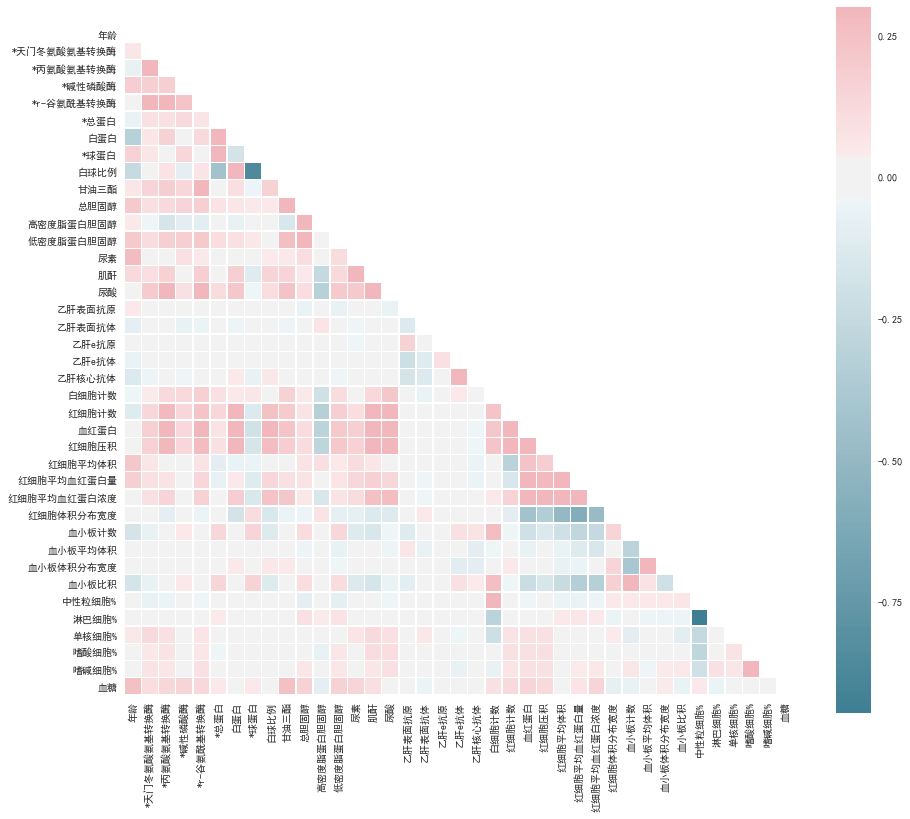

In [5]:
corr = train_data.loc[:, '年龄':].corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig_corr, ax_corr = plt.subplots(figsize=(15, 13))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
           square=True, linewidth=.5, ax=ax_corr)

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(-50, 810)

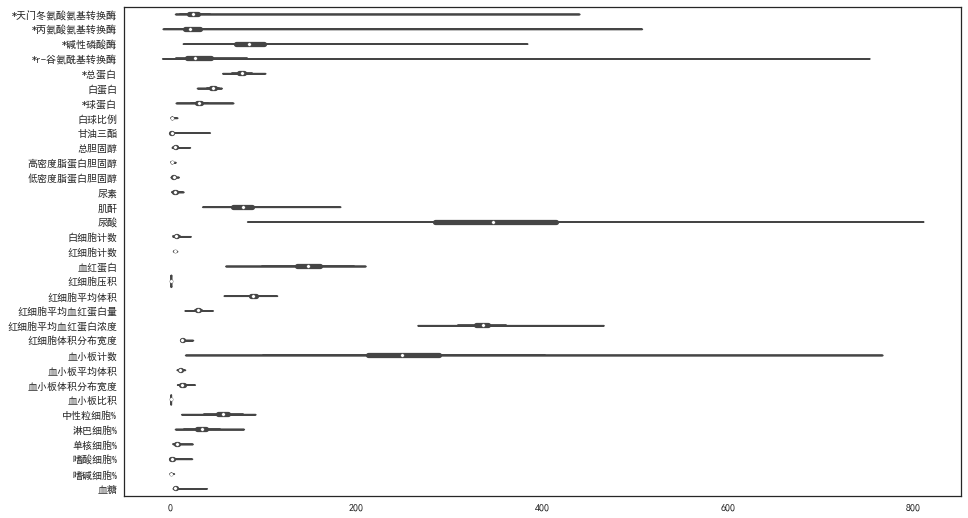

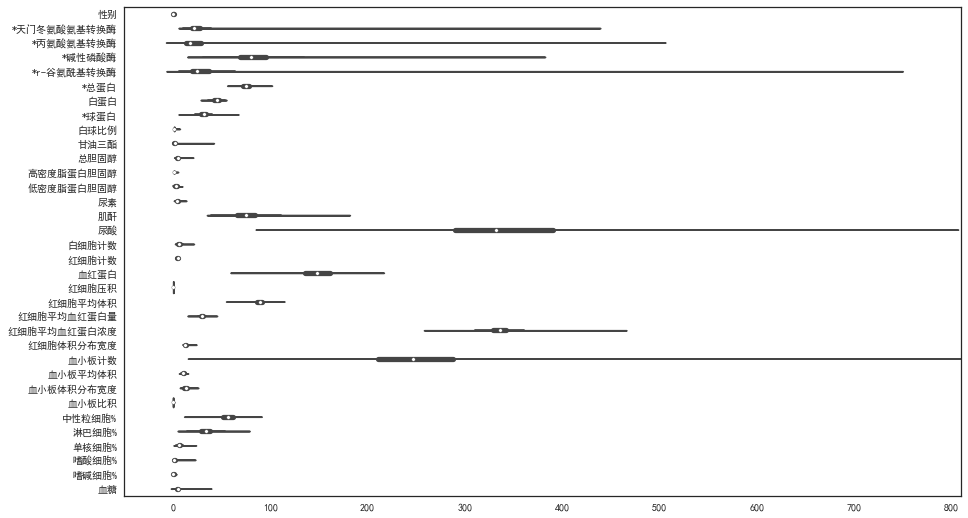

In [6]:
fig_boxt, ax_boxt = plt.subplots(figsize=(15, 9))
XTrain = train_data.loc[:, [column for column in train_data.columns if column not in 
                        ['id', '年龄', '体检日期', '乙肝表面抗原',
                         '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体',
                         'dayofyear']]]
sns.violinplot(data=XTrain, orient="h", ax=ax_boxt)

fig_boxa, ax_boxa = plt.subplots(figsize=(15, 9))
XALL = data.loc[:, [column for column in train_data.columns if column not in 
                    ['id', '年龄', '体检日期', '乙肝表面抗原',
                     '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体',
                     'dayofyear']]]
sns.violinplot(data=XALL, orient="h", ax=ax_boxa)
ax_boxa.set_xlim(left=-50, right=810)

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
D:\Anaconda3\lib\site-packages\seaborn\categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


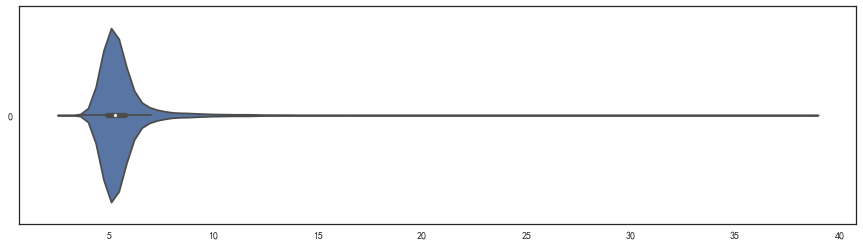

In [7]:
fig_gluvalue, ax_gluvalue = plt.subplots(figsize=(15, 4))
sns.violinplot(data=train_data['血糖'], orient="h", ax=ax_gluvalue)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


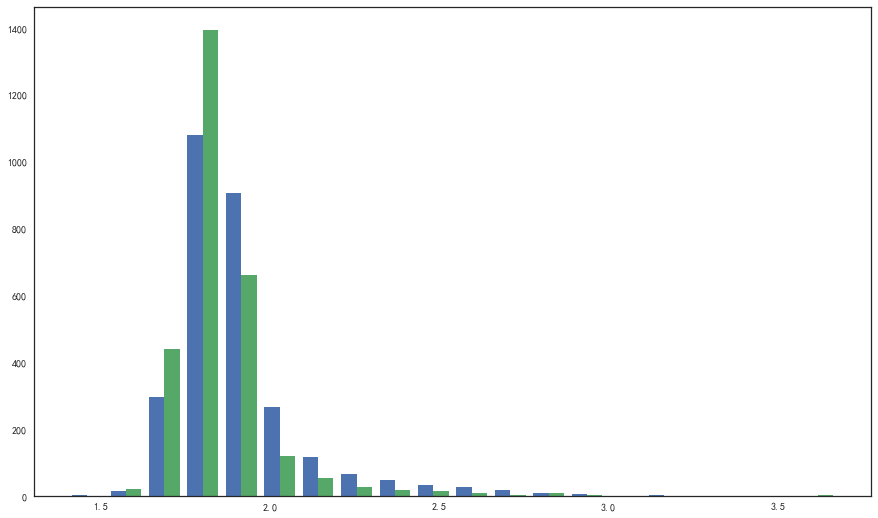

In [8]:
from scipy.special import boxcox1p
fig_gluhist, ax_gluhist = plt.subplots(figsize=(15, 9))
n, bins, pathes = ax_gluhist.hist([np.log1p(train_data.loc[train_data['性别'] == '男', '血糖']), 
                                   np.log1p(train_data.loc[train_data['性别'] == '女', '血糖'])],
                                   bins=20)

33


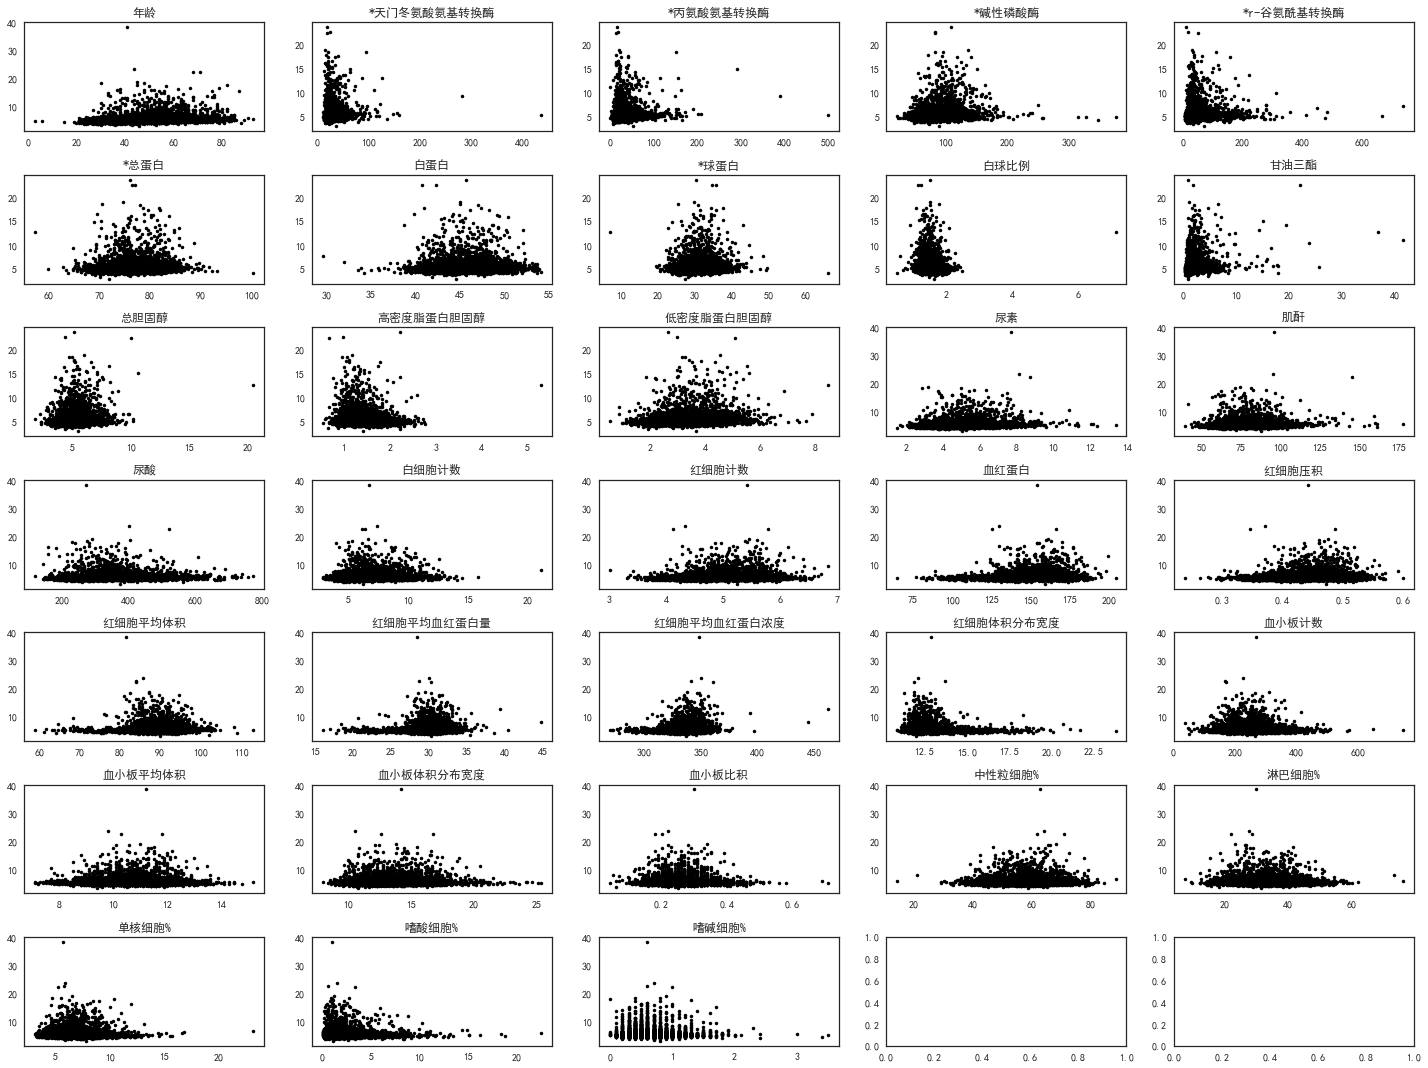

In [9]:
origin_feature = [column for column in train_data.columns if column not in ['id', '性别', '血糖', '体检日期', '乙肝表面抗原',
                         '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体']]
print(len(origin_feature))
fig_f2o, ax_f2o = plt.subplots(7, 5, figsize=(20, 15))
for idx, col in enumerate(origin_feature):
    ax_f2o[idx//5, idx%5].plot(train_data[col], train_data['血糖'], 'k.')
    ax_f2o[idx//5, idx%5].set_title(col)
fig_f2o.tight_layout()

In [10]:
train = fillna(train_data)
train = add_feature(train)

D:\Anaconda3\lib\site-packages\lightgbm\basic.py:1029: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['性别']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\Anaconda3\lib\site-packages\lightgbm\basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


In [11]:
XALL = train.loc[:, [column for column in train.columns if column not in ['id', '体检日期', '血糖', '性别']]]
yALL = train.loc[:, '血糖']
feature_col = XALL.columns
scaler = StandardScaler()
XALL = scaler.fit_transform(XALL)
XALL = pd.DataFrame(XALL, columns=feature_col)

all_set = lgb.Dataset(XALL, label=yALL)
gbm = lgb.train(variables.lgb_params, all_set,
                num_boost_round=10000,
                early_stopping_rounds=variables.early_stopping_rounds,
                valid_sets=[all_set],
                verbose_eval=100,
                feval=mse)
glu = gbm.predict(XALL)

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 1.99063	training's mse: 0.995376
[200]	training's l2: 1.79164	training's mse: 0.895838
[300]	training's l2: 1.64395	training's mse: 0.821963
[400]	training's l2: 1.51506	training's mse: 0.757528
[500]	training's l2: 1.40775	training's mse: 0.703827
[600]	training's l2: 1.31007	training's mse: 0.655109
[700]	training's l2: 1.2239	training's mse: 0.612008
[800]	training's l2: 1.1399	training's mse: 0.56992
[900]	training's l2: 1.06784	training's mse: 0.533961
[1000]	training's l2: 1.00084	training's mse: 0.50042
[1100]	training's l2: 0.938276	training's mse: 0.469142
[1200]	training's l2: 0.881914	training's mse: 0.440977
[1300]	training's l2: 0.830146	training's mse: 0.415043
[1400]	training's l2: 0.783022	training's mse: 0.391532
[1500]	training's l2: 0.737537	training's mse: 0.368814
[1600]	training's l2: 0.699345	training's mse: 0.349701
[1700]	training's l2: 0.662351	training's mse: 0.331142
[1800]	t

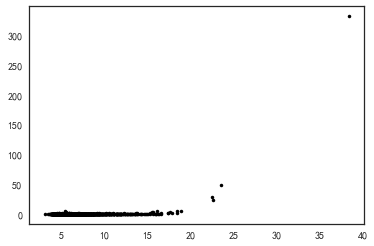

In [12]:
mse_loss = (glu - yALL)**2
fig_loss, ax_loss = plt.subplots()
ax_loss.plot(yALL, mse_loss, 'k.', lw=0.1)

In [13]:
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif

vif_dict = calculate_vif_(XALL)

vif_df = pd.DataFrame()
vif_df['variables'] = vif_dict.keys()
vif_df['vif_score'] = vif_dict.values()
vif_df.sort_values(by=['vif_score'], ascending=False, inplace=True)
valid_var = vif_df[vif_df['vif_score'] <= 5]
var_with_MC = vif_df[vif_df['vif_score'] > 5]

fig_collinear,ax_collinear = plt.subplots(ncols=2)
fig_collinear.set_size_inches(20,8)
sns.barplot(data=valid_var,x="vif_score",y="variables",ax=ax_collinear[0],orient="h",color="#34495e")
sns.barplot(data=var_with_MC,x="vif_score",y="variables",ax=ax_collinear[1],orient="h",color="#34495e")
ax_collinear[0].set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax_collinear[1].set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

D:\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'Features'),
 Text(0.5,0,'VIF Scores'),
 Text(0.5,1,'Variables Which Exhibit Multicollinearity')]